# Data Ingestion

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [2]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [3]:
import numpy as np

trajectories = {}
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
        trajectories[key] = value

In [4]:
import numpy as np
import torch

# Assume your 'trajectories' dictionary is already loaded

# Define your target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

# 1. Define your data splits
# Pool most trajectories for training/validation during optimization.
# Hold out 1-2 trajectories that the model will NEVER see during optimization.
train_val_keys = [f'kukatraj{i}' for i in range(1, 9)]  # e.g., Trajectories 1-8
final_test_keys = ['kukatraj9', 'kukatraj10']         # e.g., Trajectories 9-10

# 2. Create the combined training/validation data pool
train_val_list = [trajectories[key] for key in train_val_keys if key in trajectories]
full_train_data = np.concatenate(train_val_list, axis=0)

# 3. Create the final, held-out test set
test_list = [trajectories[key] for key in final_test_keys if key in trajectories]
full_test_data = np.concatenate(test_list, axis=0)

# 4. Create full X and y tensors and move them to the GPU
# This is the data pool Optuna's K-Fold will use.
X_train_full = torch.from_numpy(full_train_data[:, :21]).float().to(device)
y_train_full = torch.from_numpy(full_train_data[:, 21:]).float().to(device)

# This is the data for the final performance report AFTER optimization.
X_test_final = torch.from_numpy(full_test_data[:, :21]).float().to(device)
y_test_final = torch.from_numpy(full_test_data[:, 21:]).float().to(device)

print(f"Training/Validation pool shape: {X_train_full.shape}")
print(f"Final held-out test set shape: {X_test_final.shape}")

Running on device: cuda
Training/Validation pool shape: torch.Size([16052, 21])
Final held-out test set shape: torch.Size([4016, 21])


# Optimisation
---

In [ ]:
import optuna
from sklearn.model_selection import KFold
import sys
sys.path.append('../pc_esn')

import model
import utils

def objective(trial):
    """
    The objective function for Optuna to optimize.
    It uses the pre-loaded GPU tensors for K-Fold Cross-Validation.
    """
    # 1. Suggest hyperparameters for this trial
    params = {
        'n_reservoir': trial.suggest_int('n_reservoir', 300, 2000),
        'spectral_radius': trial.suggest_float('spectral_radius', 0.5, 1),
        'sparsity': trial.suggest_float('sparsity', 0.6, 0.95),
        'leak_rate': trial.suggest_float('leak_rate', 0.25, 1),
        'ghl_eta': trial.suggest_float('ghl_eta', 1e-6, 1e-3, log=True),
        'ghl_decay_steps': trial.suggest_int('ghl_decay_steps', 1000, 10000)
    }

    # 2. Perform K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_errors = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        print(f"--- Trial {trial.number}, Fold {fold+1} ---")
        
        # Slicing creates views of the GPU tensors, no data is moved
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

        # Instantiate the model with trial params, ensuring it's on the correct device
        model = model.PC_ESN(
            n_inputs=X_train.shape[1],
            n_outputs=y_train.shape[1],
            n_reservoir=params['n_reservoir'],
            spectral_radius=params['spectral_radius'],
            sparsity=params['sparsity'],
            leak_rate=params['leak_rate'],
            ghl_eta=params['ghl_eta'],
            ghl_decay_steps=params['ghl_decay_steps'],
            device=device  # Pass the device to the model
        )

        model.train(X_train, y_train)
        predictions = model.predict_full_trajectory(X_val)
        
        # Calculate nMSE
        true_values = y_val.cpu().numpy() # Move to CPU only for numpy calculation
        error = np.mean((predictions - true_values)**2)
        variance = np.var(true_values)
        
        # Avoid division by zero if variance is tiny
        nMSE = error / (variance + 1e-9)
        fold_errors.append(nMSE)

    # 3. Return the average error across all folds
    average_nMSE = np.mean(fold_errors)
    print(f"--- Trial {trial.number} complete. Average nMSE: {average_nMSE:.6f} ---")
    
    return average_nMSE

In [7]:
# Create a study object. "minimize" is the goal for our error metric.
study = optuna.create_study(direction='minimize')

# Start the optimization. Optuna will run for 100 trials.
# This will take time!
study.optimize(objective, n_trials=30)

# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-08 20:24:40,653] A new study created in memory with name: no-name-bd00aba7-a8c3-4d0b-a03d-e2ff80ea4572


--- Trial 0, Fold 1 ---
--- Trial 0, Fold 2 ---
--- Trial 0, Fold 3 ---
--- Trial 0, Fold 4 ---
--- Trial 0, Fold 5 ---


[I 2025-07-08 20:53:02,656] Trial 0 finished with value: 0.2960950946720128 and parameters: {'n_reservoir': 1741, 'spectral_radius': 0.766966620437737, 'sparsity': 0.819178334230598, 'leak_rate': 0.9549751748379032, 'ghl_eta': 1.0283251634353872e-05, 'ghl_decay_steps': 5071}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 0 complete. Average nMSE: 0.296095 ---
--- Trial 1, Fold 1 ---
--- Trial 1, Fold 2 ---
--- Trial 1, Fold 3 ---
--- Trial 1, Fold 4 ---
--- Trial 1, Fold 5 ---


[I 2025-07-08 21:18:52,129] Trial 1 finished with value: 0.5859749946707989 and parameters: {'n_reservoir': 1580, 'spectral_radius': 0.7683444613718873, 'sparsity': 0.6530555915301484, 'leak_rate': 0.9116291904856719, 'ghl_eta': 2.148585126062341e-06, 'ghl_decay_steps': 1746}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 1 complete. Average nMSE: 0.585975 ---
--- Trial 2, Fold 1 ---
--- Trial 2, Fold 2 ---
--- Trial 2, Fold 3 ---
--- Trial 2, Fold 4 ---
--- Trial 2, Fold 5 ---


[I 2025-07-08 21:33:03,443] Trial 2 finished with value: 1.3292471809635489 and parameters: {'n_reservoir': 1325, 'spectral_radius': 0.9393395531534942, 'sparsity': 0.9247688045955806, 'leak_rate': 0.31757616403178685, 'ghl_eta': 4.706074488199002e-05, 'ghl_decay_steps': 3281}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 2 complete. Average nMSE: 1.329247 ---
--- Trial 3, Fold 1 ---
--- Trial 3, Fold 2 ---
--- Trial 3, Fold 3 ---
--- Trial 3, Fold 4 ---
--- Trial 3, Fold 5 ---


[I 2025-07-08 21:38:49,240] Trial 3 finished with value: 0.5325723776119686 and parameters: {'n_reservoir': 793, 'spectral_radius': 0.9798610200661901, 'sparsity': 0.9452535730663572, 'leak_rate': 0.6986394553147282, 'ghl_eta': 0.0003777585026137732, 'ghl_decay_steps': 8517}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 3 complete. Average nMSE: 0.532572 ---
--- Trial 4, Fold 1 ---
--- Trial 4, Fold 2 ---
--- Trial 4, Fold 3 ---
--- Trial 4, Fold 4 ---
--- Trial 4, Fold 5 ---


[I 2025-07-08 21:46:35,173] Trial 4 finished with value: 0.5028731392911947 and parameters: {'n_reservoir': 978, 'spectral_radius': 0.8182423676396131, 'sparsity': 0.8475878636290848, 'leak_rate': 0.9400528378204324, 'ghl_eta': 0.0004922864580028812, 'ghl_decay_steps': 5426}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 4 complete. Average nMSE: 0.502873 ---
--- Trial 5, Fold 1 ---
--- Trial 5, Fold 2 ---
--- Trial 5, Fold 3 ---
--- Trial 5, Fold 4 ---
--- Trial 5, Fold 5 ---


[I 2025-07-08 22:23:36,950] Trial 5 finished with value: 0.641312818088411 and parameters: {'n_reservoir': 1833, 'spectral_radius': 0.9349410599407675, 'sparsity': 0.8428153916710671, 'leak_rate': 0.9005643074603191, 'ghl_eta': 1.4936059515259761e-05, 'ghl_decay_steps': 1195}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 5 complete. Average nMSE: 0.641313 ---
--- Trial 6, Fold 1 ---
--- Trial 6, Fold 2 ---
--- Trial 6, Fold 3 ---
--- Trial 6, Fold 4 ---
--- Trial 6, Fold 5 ---


[W 2025-07-08 22:45:02,974] Trial 6 failed with parameters: {'n_reservoir': 1461, 'spectral_radius': 0.5879569014027104, 'sparsity': 0.7802449406604535, 'leak_rate': 0.4175614968439161, 'ghl_eta': 0.0008079479651637719, 'ghl_decay_steps': 8885} because of the following error: The value nan is not acceptable.
[W 2025-07-08 22:45:02,974] Trial 6 failed with value nan.


--- Trial 6 complete. Average nMSE: nan ---
--- Trial 7, Fold 1 ---
--- Trial 7, Fold 2 ---
--- Trial 7, Fold 3 ---
--- Trial 7, Fold 4 ---
--- Trial 7, Fold 5 ---


[I 2025-07-08 22:56:56,556] Trial 7 finished with value: 1.3228392252183543 and parameters: {'n_reservoir': 1223, 'spectral_radius': 0.9242529724515194, 'sparsity': 0.6861773944837675, 'leak_rate': 0.3393613615086522, 'ghl_eta': 0.00034280116347111365, 'ghl_decay_steps': 9215}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 7 complete. Average nMSE: 1.322839 ---
--- Trial 8, Fold 1 ---
--- Trial 8, Fold 2 ---
--- Trial 8, Fold 3 ---
--- Trial 8, Fold 4 ---
--- Trial 8, Fold 5 ---


[I 2025-07-08 23:12:11,860] Trial 8 finished with value: 0.8439886901428985 and parameters: {'n_reservoir': 1370, 'spectral_radius': 0.7411551966956105, 'sparsity': 0.8318263176982229, 'leak_rate': 0.5270489871251226, 'ghl_eta': 0.0001857149557208431, 'ghl_decay_steps': 2694}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 8 complete. Average nMSE: 0.843989 ---
--- Trial 9, Fold 1 ---
--- Trial 9, Fold 2 ---
--- Trial 9, Fold 3 ---
--- Trial 9, Fold 4 ---
--- Trial 9, Fold 5 ---


[I 2025-07-08 23:21:48,811] Trial 9 finished with value: 0.3976682546200045 and parameters: {'n_reservoir': 1025, 'spectral_radius': 0.5000267249888997, 'sparsity': 0.8826927454425291, 'leak_rate': 0.9192532779042047, 'ghl_eta': 3.6367850314565734e-05, 'ghl_decay_steps': 4970}. Best is trial 0 with value: 0.2960950946720128.


--- Trial 9 complete. Average nMSE: 0.397668 ---
--- Trial 10, Fold 1 ---
--- Trial 10, Fold 2 ---
--- Trial 10, Fold 3 ---
--- Trial 10, Fold 4 ---
--- Trial 10, Fold 5 ---


[I 2025-07-08 23:31:47,497] Trial 10 finished with value: 0.2951888635921943 and parameters: {'n_reservoir': 1098, 'spectral_radius': 0.7833705005459499, 'sparsity': 0.7955256115601115, 'leak_rate': 0.966262156031272, 'ghl_eta': 3.092440071049711e-06, 'ghl_decay_steps': 2837}. Best is trial 10 with value: 0.2951888635921943.


--- Trial 10 complete. Average nMSE: 0.295189 ---
--- Trial 11, Fold 1 ---
--- Trial 11, Fold 2 ---
--- Trial 11, Fold 3 ---
--- Trial 11, Fold 4 ---
--- Trial 11, Fold 5 ---


[I 2025-07-08 23:37:23,623] Trial 11 finished with value: 1.0384103351482392 and parameters: {'n_reservoir': 340, 'spectral_radius': 0.6237377693040802, 'sparsity': 0.7388625925581588, 'leak_rate': 0.6860603260245408, 'ghl_eta': 1.0824577256094053e-06, 'ghl_decay_steps': 6927}. Best is trial 10 with value: 0.2951888635921943.


--- Trial 11 complete. Average nMSE: 1.038410 ---
--- Trial 12, Fold 1 ---


[W 2025-07-08 23:41:16,924] Trial 12 failed with parameters: {'n_reservoir': 1953, 'spectral_radius': 0.6776734919140176, 'sparsity': 0.772531487282276, 'leak_rate': 0.8033125894685851, 'ghl_eta': 7.256978122466402e-06, 'ghl_decay_steps': 3869} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_112/979185095.py", line 45, in objective
    model.train(X_train, y_train)
  File "/tmp/ipykernel_112/1534708573.py", line 132, in train
    self._update_output_weights(y_data[t])
  File "/tmp/ipykernel_112/1534708573.py", line 121, in _update_output_weights
    term2 = tau_t**2
            ~~~~~^^~
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 39, in wrapped
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
[W 2025-07

KeyboardInterrupt: 

In [11]:
# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Optimization finished!
Best trial:
  Value (nMSE): 0.2951888635921943
  Params: 
    n_reservoir: 1098
    spectral_radius: 0.7833705005459499
    sparsity: 0.7955256115601115
    leak_rate: 0.966262156031272
    ghl_eta: 3.092440071049711e-06
    ghl_decay_steps: 2837


In [10]:
import plotly.express
optuna.visualization.plot_param_importances(study).show()

In [9]:
optuna.visualization.plot_slice(study, params=['n_reservoir', 'leak_rate', 'spectral_radius']).show()

# Eval functions
---

In [12]:
def get_transformation_matrix(theta, d, a, alpha):
    """
    Calculates the transformation matrix for a single joint using Denavit-Hartenberg (DH) parameters.
    This matrix represents the position and orientation of one joint's frame relative to the previous one.
    """
    # Pre-calculate sine and cosine for efficiency
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)
    c_alpha = np.cos(alpha)
    s_alpha = np.sin(alpha)
    
    # Construct the 4x4 transformation matrix
    A = np.array([
        [c_theta, -s_theta * c_alpha,  s_theta * s_alpha, a * c_theta],
        [s_theta,  c_theta * c_alpha, -c_theta * s_alpha, a * s_theta],
        [0,       s_alpha,            c_alpha,           d],
        [0,       0,                  0,                 1]
    ])
    return A

In [13]:
def calculate_op_space_error(y_true, y_pred):
    """
    Calculates the mean Euclidean error in the operational space for a full trajectory.
    y_true and y_pred are arrays of shape (n_samples, 14).
    """
    # Extract just the position columns (first 7 columns) from the target and prediction arrays
    true_joint_positions = y_true[:, :7]
    pred_joint_positions = y_pred[:, :7]
    
    # Apply the forward_kinematics function to every row (i.e., every time step)
    true_xyz_coords = np.apply_along_axis(forward_kinematics, 1, true_joint_positions)
    pred_xyz_coords = np.apply_along_axis(forward_kinematics, 1, pred_joint_positions)
    
    # Calculate the Euclidean distance between the true and predicted xyz coordinates for each time step
    errors = np.linalg.norm(true_xyz_coords - pred_xyz_coords, axis=1)
    
    # Return the average error over the whole trajectory
    return np.mean(errors)

In [14]:
def forward_kinematics(joint_positions):
    if isinstance(joint_positions, torch.Tensor):
        joint_positions = joint_positions.cpu().numpy()
    if joint_positions.ndim == 1:
        joint_positions = joint_positions.reshape(1, -1)
    x = np.cos(joint_positions[:, 0]) + np.sin(joint_positions[:, 1])
    y = np.sin(joint_positions[:, 0]) + np.cos(joint_positions[:, 2])
    z = joint_positions[:, 3] + joint_positions[:, 4]
    return np.stack([x, y, z], axis=1)

In [15]:
# --- 3. Evaluation Functions ---
def nMSE(y_true, y_pred):
    error = np.mean((y_true - y_pred)**2, axis=0)
    variance = np.var(y_true, axis=0)
    variance[variance == 0] = 1
    return error / variance

def euclidean_error(y_true, y_pred):
    ee_pos_true = forward_kinematics(y_true[:, :7])
    ee_pos_pred = forward_kinematics(y_pred[:, :7])
    return np.linalg.norm(ee_pos_true - ee_pos_pred, axis=1)

# In-depth Evaluation
---

In [ ]:
import time

overall_start_time = time.time()
trajectory_keys = sorted(list(trajectories.keys()))

# Hyperparameters from pc-esn++ implementation 
N_RESERVOIR = 1098
SPECTRAL_RADIUS = 0.7833
SPARSITY = 0.7955
LEAK_RATE = 0.966

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- PC-ESN++ Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)

--- PC-ESN++ Evaluation Setup ---
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Trajectories: 10
---------------------------------


In [ ]:
fold_results = []

for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train, y_train = train_traj[:, :21], train_traj[:, 21:]
    X_test, y_test = test_traj[:, :21], test_traj[:, 21:]

    X_train_t = torch.from_numpy(X_train).float().to(device)
    y_train_t = torch.from_numpy(y_train).float().to(device)
    X_test_t = torch.from_numpy(X_test).float().to(device)

    # Model Training
    model = model.PC_ESN(n_inputs=21, n_outputs=14, n_reservoir=N_RESERVOIR,
               spectral_radius=SPECTRAL_RADIUS, sparsity=SPARSITY,
               leak_rate=LEAK_RATE, device=device)
    
    train_time_start = time.time()
    model.train(X_train_t, y_train_t)
    training_time = time.time() - train_time_start
    print(f"Training complete in {training_time:.2f} seconds.")

    # Evaluation
    # Scenario A: Step-by-step prediction
    y_pred_step = model.predict_step_by_step(X_test_t)
    
    # Scenario B: Full trajectory prediction
    y_pred_full = model.predict_full_trajectory(X_test_t)

    # Calculate Metrics
    nmse_step = nMSE(y_test, y_pred_step)
    nmse_full = nMSE(y_test, y_pred_full)
    euclid_err_step = euclidean_error(y_test, y_pred_step)
    euclid_err_op_space_full = calculate_op_space_error(y_test, y_pred_full)
    
    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]), 'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'full_pos_nmse': np.mean(nmse_full[:7]), 'full_vel_nmse': np.mean(nmse_full[7:]),
        'sbs_euclid_err': np.mean(euclid_err_step),
        'full_op_space_error': np.mean(euclid_err_op_space_full)
    }

    # Horizon Analysis
    horizons = sorted(list(set([100, 200, 500, 1000, 1500, y_pred_full.shape[0]-1])))
    for h in horizons:
        nmse_h = nMSE(y_test[:h], y_pred_full[:h])
        euclid_h = euclidean_error(y_test[:h], y_pred_full[:h])
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = np.mean(euclid_h)
    
    fold_results.append(current_fold_results)
    print(f"Fold {i+1} evaluation complete. Total time: {time.time() - fold_start_time:.2f}s")
    
    if i == len(trajectory_keys) - 1:
        last_fold_preds = {'true': y_test, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: kukatraj1
Training complete in 168.02 seconds.
Fold 1 evaluation complete. Total time: 169.31s

--- Fold 2/10 ---
Testing on: kukatraj10
Training complete in 166.38 seconds.
Fold 2 evaluation complete. Total time: 167.73s

--- Fold 3/10 ---
Testing on: kukatraj2
Training complete in 167.62 seconds.
Fold 3 evaluation complete. Total time: 168.94s

--- Fold 4/10 ---
Testing on: kukatraj3
Training complete in 166.60 seconds.
Fold 4 evaluation complete. Total time: 167.94s

--- Fold 5/10 ---
Testing on: kukatraj4
Training complete in 166.88 seconds.
Fold 5 evaluation complete. Total time: 168.25s

--- Fold 6/10 ---
Testing on: kukatraj5
Training complete in 167.12 seconds.
Fold 6 evaluation complete. Total time: 168.46s

--- Fold 7/10 ---
Testing on: kukatraj6
Training complete in 165.80 seconds.
Fold 7 evaluation complete. Total time: 167.24s

--- Fold 8/10 ---
Testing on: kukatraj7
Training complete in 166.48 seconds.
Fold 8 evaluation complete. Total time:

In [18]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
for h in horizons:
    h_col_pos, h_col_euc = f'full_pos_nmse_h{h}', f'full_euclid_err_h{h}'
    if h_col_pos in mean_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 28.13 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 166.27 ± 1.75
Step-by-Step Pos nMSE       | 4.0129 ± 3.8042
Step-by-Step Vel nMSE       | 13.9970 ± 6.5743
Step-by-Step Euclid Err (m) | 0.6670 ± 0.1868
Full Traj Pos nMSE          | 4.1921 ± 3.4800
Full Traj Vel nMSE          | 8.8538 ± 4.1394
Full Traj Euclid Err (m) | 0.3573 ± 0.1066
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 1084607137.1855 ± 2233090730.5918      | 0.0141 ± 0.0047
200     | 569362500.7590 ± 1206434034.9412      | 0.0154 ± 0.0032
500     | 469.0989 ± 1108.4352      | 0.1895 ± 0.0864
1000    | 11.4906 ± 15.1089  

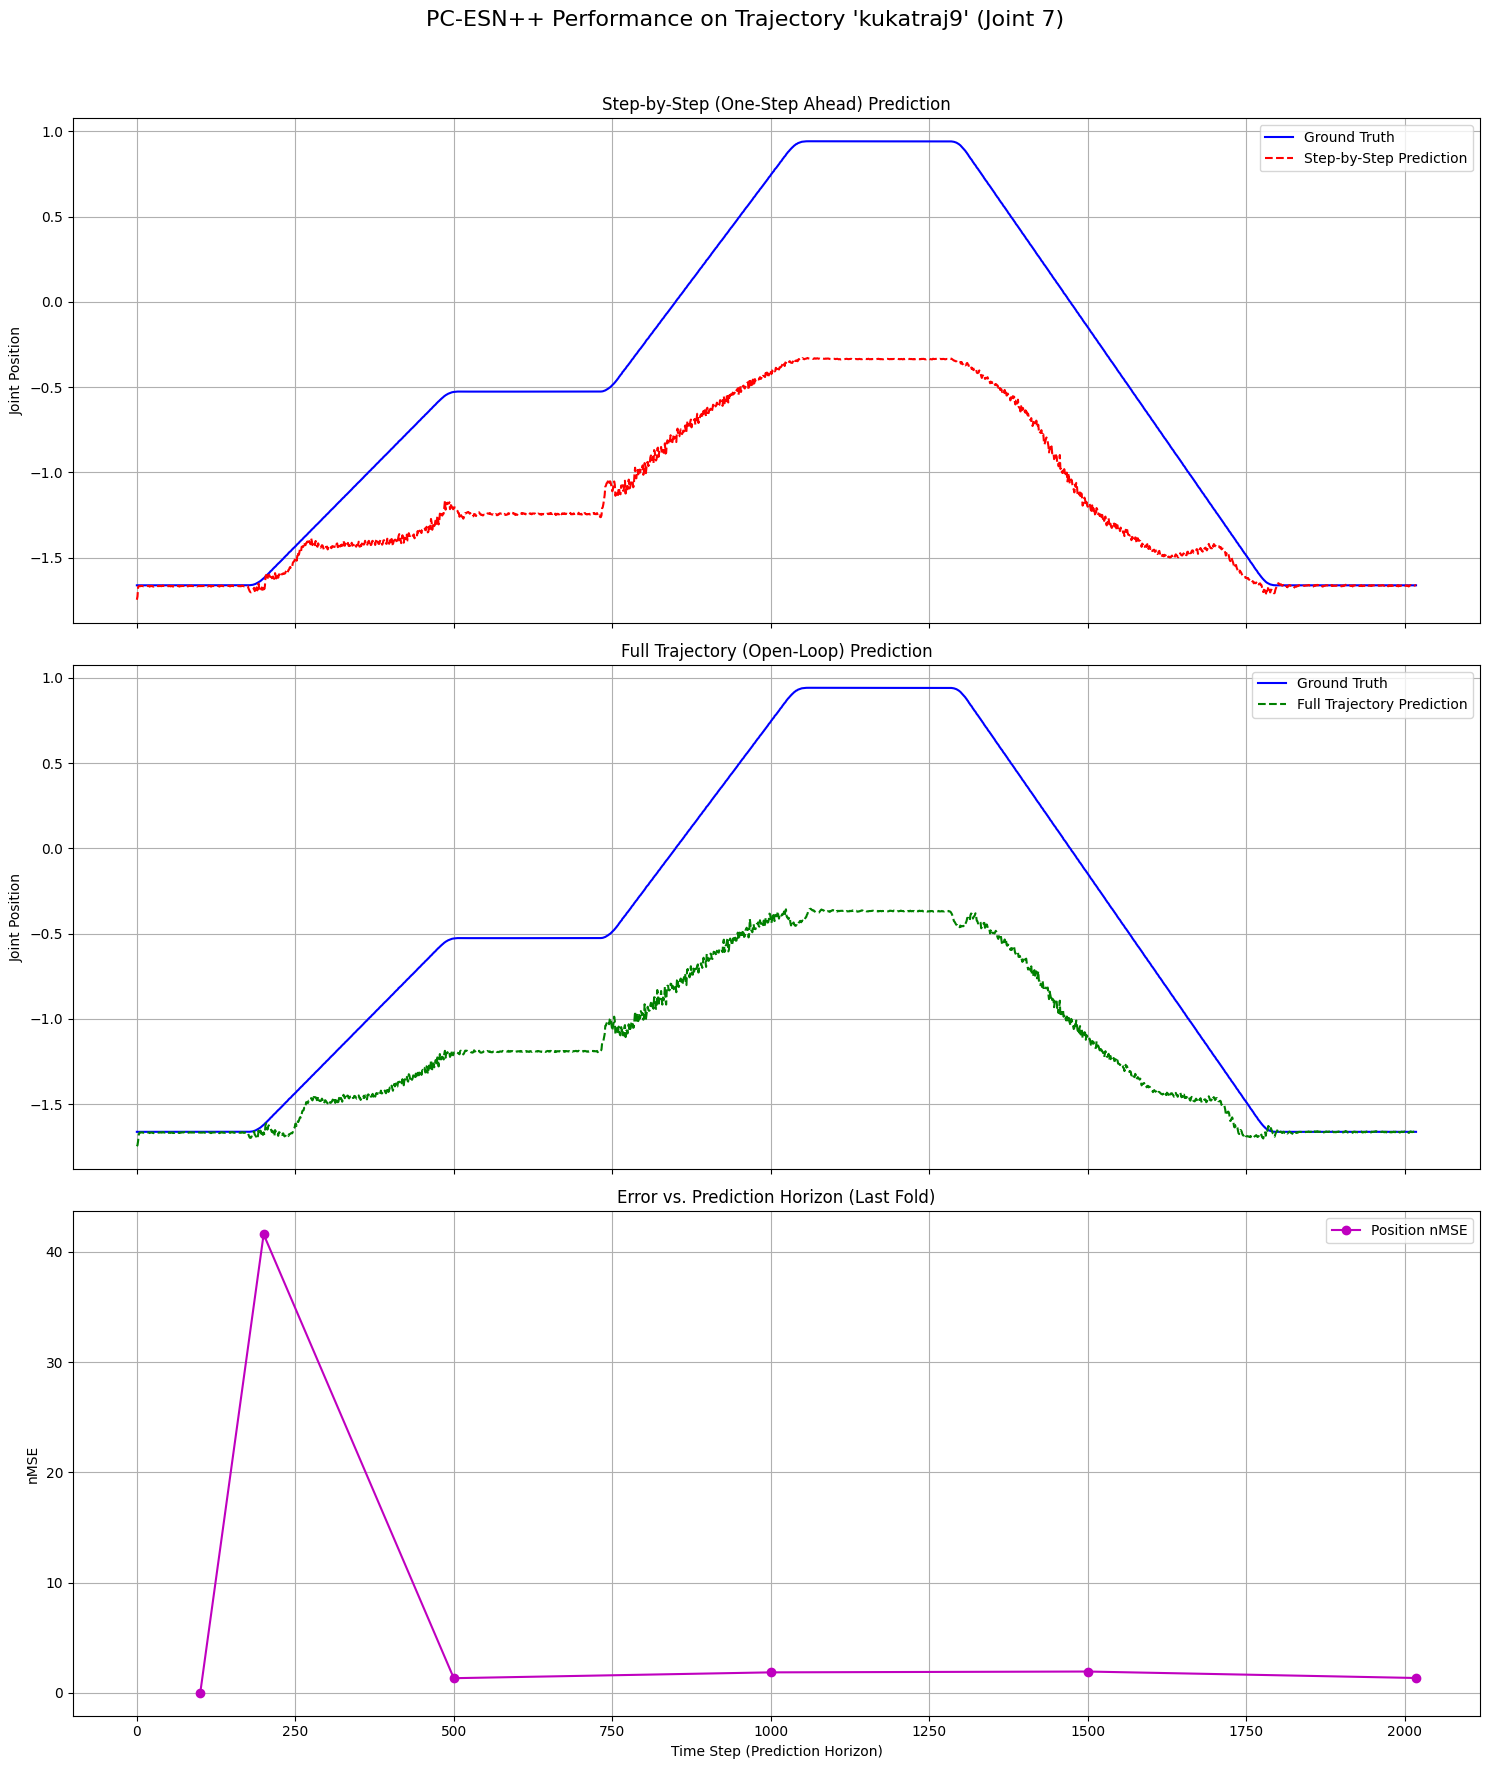

In [19]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [20]:
from scipy import stats

# --- Statistical Significance Test ---
print("\n--- Example of Statistical Significance Test ---")
baseline_results = {'full_pos_nmse': results_df['full_pos_nmse'] * (1.5 + np.random.rand(10) * 0.5)}
baseline_df = pd.DataFrame(baseline_results)
t_stat, p_value = stats.ttest_rel(results_df['full_pos_nmse'], baseline_df['full_pos_nmse'])
print("Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05: print("The difference is statistically significant (p < 0.05).")
else: print("The difference is not statistically significant.")


--- Example of Statistical Significance Test ---
Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):
T-statistic: -3.4930, P-value: 0.0068
The difference is statistically significant (p < 0.05).


(0.0051136985421180725,
 1.5980506464838982,
 -0.6073511958122253,
 0.5751787543296814)

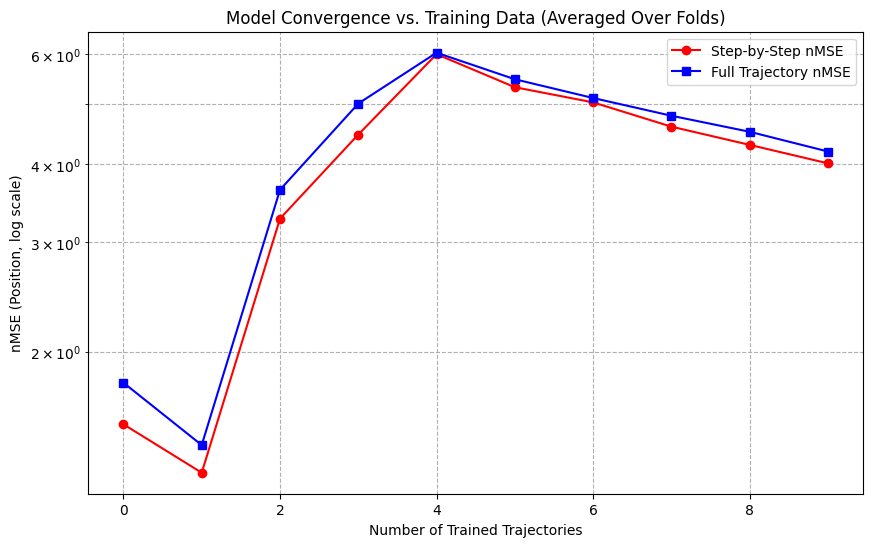

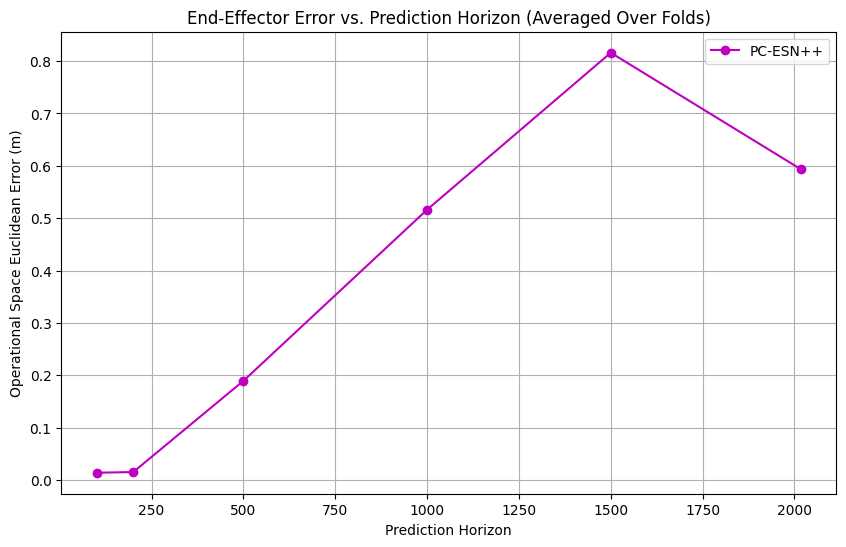

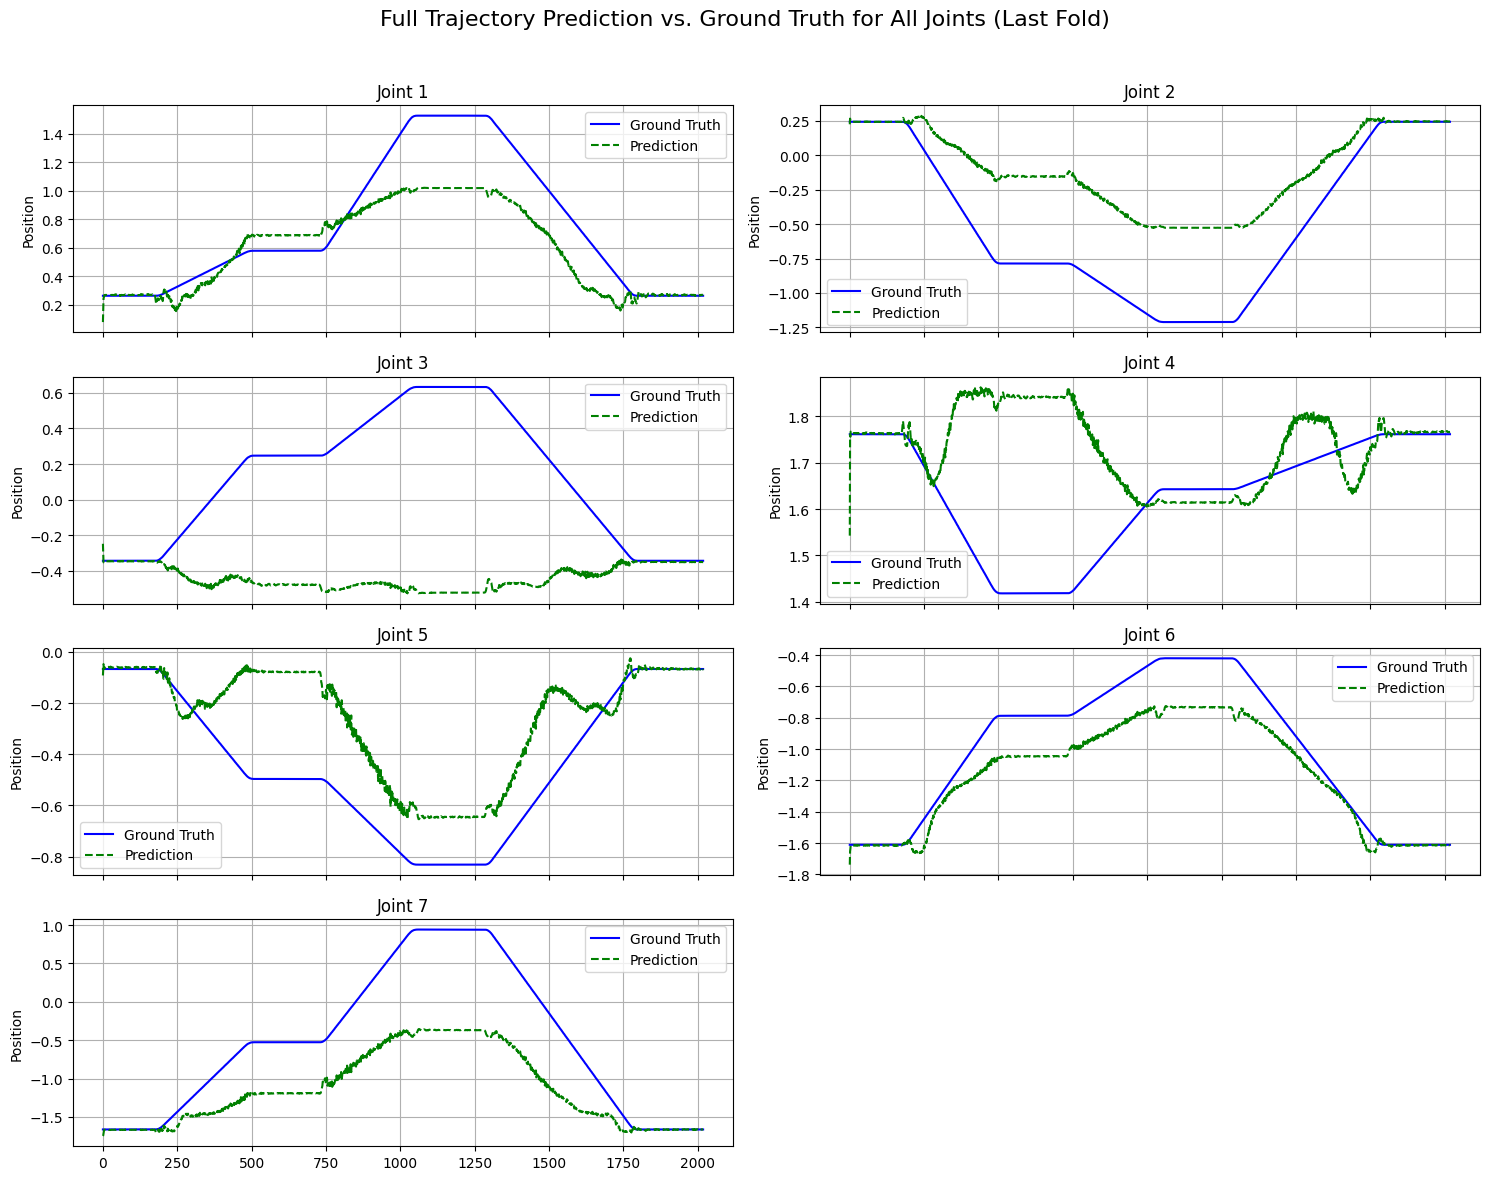

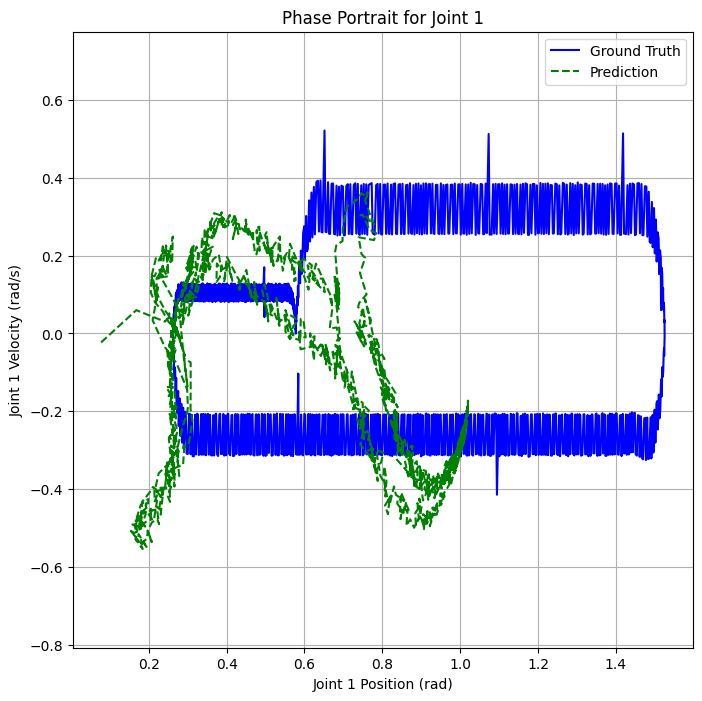

In [21]:
# --- Plot 1: Convergence Plot (Replicating Paper's Fig. 5) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
num_trajectories = np.arange(1, len(results_df) + 1)
ax1.plot(results_df['sbs_pos_nmse'].expanding().mean(), 'r-o', label='Step-by-Step nMSE')
ax1.plot(results_df['full_pos_nmse'].expanding().mean(), 'b-s', label='Full Trajectory nMSE')
ax1.set_yscale('log'); ax1.set_xlabel('Number of Trained Trajectories'); ax1.set_ylabel('nMSE (Position, log scale)')
ax1.set_title('Model Convergence vs. Training Data (Averaged Over Folds)'); ax1.legend(); ax1.grid(True, which="both", ls="--")

# --- Plot 2: Operational Space Error vs. Horizon (Replicating Paper's Fig. 6) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
horizon_cols = [f'full_euclid_err_h{h}' for h in horizons if f'full_euclid_err_h{h}' in results_df.columns]

mean_op_errors = results_df[horizon_cols].mean()
ax2.plot(horizons, mean_op_errors.values, 'm-o', label='PC-ESN++')
ax2.set_xlabel('Prediction Horizon'); ax2.set_ylabel('Operational Space Euclidean Error (m)')
ax2.set_title('End-Effector Error vs. Prediction Horizon (Averaged Over Folds)'); ax2.legend(); ax2.grid(True)

# --- Plot 3: All Joints Full Trajectory Prediction ---
fig3, axs3 = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig3.suptitle('Full Trajectory Prediction vs. Ground Truth for All Joints (Last Fold)', fontsize=16)
axs3 = axs3.ravel()
for i in range(7):
    axs3[i].plot(last_fold_preds['true'][:, i], 'b-', label='Ground Truth')
    axs3[i].plot(last_fold_preds['full'][:, i], 'g--', label='Prediction')
    axs3[i].set_title(f'Joint {i+1}'); axs3[i].set_ylabel('Position'); axs3[i].grid(True); axs3[i].legend()
axs3[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

# --- Plot 4: Phase Portrait for a Sample Joint (SAFEGUARD ADDED) ---
fig4, ax4 = plt.subplots(figsize=(8, 8))
joint_to_plot = 0

ax4.plot(last_fold_preds['true'][:, joint_to_plot], last_fold_preds['true'][:, joint_to_plot + 7], 'b-', label='Ground Truth')
ax4.plot(last_fold_preds['full'][:, joint_to_plot], last_fold_preds['full'][:, joint_to_plot + 7], 'g--', label='Prediction')
ax4.set_xlabel(f'Joint {joint_to_plot+1} Position (rad)'); ax4.set_ylabel(f'Joint {joint_to_plot+1} Velocity (rad/s)')
ax4.set_title(f'Phase Portrait for Joint {joint_to_plot+1}'); ax4.legend(); ax4.grid(True); ax4.axis('equal')